## Assignment – Using the latest data, find out the best pinch hitters inside PP in the IPL so far (min of 20 ings)

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)
pd.set_option('display.expand_frame_repr',False)
pd.set_option('max_colwidth',-1)

In [2]:
main_df = pd.read_csv('cleaned_ipl_dataset_2008_to_2022.csv')

In [3]:
df = main_df.copy()

In [4]:
def BPB(balls,boundaries):
    if boundaries == 0:
        return balls/1
    else:
        return balls/boundaries
def BPD(balls,dismissals):
    if dismissals == 0:
        return balls/1
    else:
        return balls/dismissals

In [5]:
def playerStats(df,current_phase):
    
    df = df[(df.phase == current_phase)]
    df.reset_index(inplace = True, drop = True)  
    
    df['Dots'] = df.runs_off_bat.apply(lambda x : 1 if x==0 else 0)
    df['Ones'] = df.runs_off_bat.apply(lambda x : 1 if x==1 else 0)
    df['Twos'] = df.runs_off_bat.apply(lambda x : 1 if x==2 else 0)
    df['Threes'] = df.runs_off_bat.apply(lambda x : 1 if x==3 else 0)
    df['Fours'] = df.runs_off_bat.apply(lambda x : 1 if x==4 else 0)
    df['Sixes'] = df.runs_off_bat.apply(lambda x : 1 if x==6 else 0)

    Innings = pd.DataFrame(df.groupby(df['striker'])['match_id'].apply(lambda x : len(list(np.unique(x))))).reset_index().rename(columns={'match_id':'innings'})
    Runs = pd.DataFrame(df.groupby(['striker'])['runs_off_bat'].sum()).reset_index().rename(columns={'runs_off_bat':'runs'})
    Balls = pd.DataFrame(df.groupby(['striker'])['legal_ball'].sum()).reset_index().rename(columns={'legal_ball':'balls'})
    Dismissals = pd.DataFrame(df.groupby(['striker'])['player_dismissed'].count()).reset_index().rename(columns={'player_dismissed':'dismissals'})
    Fours = pd.DataFrame(df.groupby(['striker'])['Fours'].sum()).reset_index().rename(columns={'Fours':'fours'})
    Sixes = pd.DataFrame(df.groupby(['striker'])['Sixes'].sum()).reset_index().rename(columns={'Sixes':'sixes'})
    Dots = pd.DataFrame(df.groupby(['striker'])['Dots'].sum()).reset_index().rename(columns={'Dots':'dots'})

    playerDf = pd.merge(Innings,Runs,on='striker').merge(Balls,on='striker').merge(Dismissals,on='striker').merge(Fours,on='striker').merge(Sixes,on='striker')

    playerDf = playerDf.rename(columns={'striker':'batter'})
    playerDf = playerDf[(playerDf.innings >= 20)]
    
    playerDf['rpi'] = playerDf.apply(lambda x : x['runs']/x['innings'], axis=1)
    playerDf['sr'] = playerDf.apply(lambda x : (x['runs']/x['balls'])*100, axis=1)
    playerDf['bpb'] = playerDf.apply(lambda x : BPB(x['balls'],(x['fours']+x['sixes'])), axis=1)
    playerDf['bpd'] = playerDf.apply(lambda x : BPB(x['balls'],x['dismissals']), axis=1)
    
    return playerDf

In [6]:
dfp = playerStats(df,'PP')
dfp.reset_index(inplace = True, drop = True)

In [7]:
wt_sr, wt_rpi, wt_bpb, wt_bpd = 0.39, 0.14, 0.18, 0.28

### Calculation - Normalizing all values to same dimensions

#step1: square of all values
dfp['calc_sr'] = dfp['sr'].apply(lambda x: x*x) 
dfp['calc_rpi'] = dfp['rpi'].apply(lambda x: x*x) 
dfp['calc_bpb'] = dfp['bpb'].apply(lambda x: x*x) 
dfp['calc_bpd'] = dfp['bpd'].apply(lambda x: x*x)

sq_sr, sq_rpi, sq_bpb, sq_bpd = np.sqrt(dfp[['calc_sr','calc_rpi', 'calc_bpb', 'calc_bpd']].sum(axis = 0))

dfp['calc_sr'] = dfp['calc_sr'].apply(lambda x: x/sq_sr) 
dfp['calc_rpi'] = dfp['calc_rpi'].apply(lambda x: x/sq_rpi) 
dfp['calc_bpb'] = dfp['calc_bpb'].apply(lambda x: x/sq_bpb) 
dfp['calc_bpd'] = dfp['calc_bpd'].apply(lambda x: x/sq_bpd)

dfp['calc_sr'] = dfp['calc_sr'].apply(lambda x: x*wt_sr) 
dfp['calc_rpi'] = dfp['calc_rpi'].apply(lambda x: x*wt_rpi) 
dfp['calc_bpb'] = dfp['calc_bpb'].apply(lambda x: x*wt_bpb) 
dfp['calc_bpd'] = dfp['calc_bpd'].apply(lambda x: x*wt_bpd)

best_sr, worst_sr = max(dfp['calc_sr']), min(dfp['calc_sr'])
best_rpi, worst_rpi = max(dfp['calc_rpi']), min(dfp['calc_rpi'])
best_bpb, worst_bpb = min(dfp['calc_bpb']), max(dfp['calc_bpb'])
best_bpd, worst_bpd = max(dfp['calc_bpd']), min(dfp['calc_bpd'])

###  Calculation - Comparision against the best & worst values

dfp['dev_best_sr'] = dfp['calc_sr'].apply(lambda x: (x-best_sr)*(x-best_sr)) 
dfp['dev_best_rpi'] = dfp['calc_rpi'].apply(lambda x: (x-best_rpi)*(x-best_rpi)) 
dfp['dev_best_bpb'] = dfp['calc_bpb'].apply(lambda x: (x-best_bpb)*(x-best_bpb)) 
dfp['dev_best_bpd'] = dfp['calc_bpd'].apply(lambda x: (x-best_bpd)*(x-best_bpd))

dfp['dev_best_sqrt'] = dfp.apply(lambda x: x['dev_best_sr'] + x['dev_best_rpi'] + x['dev_best_bpb'] + x['dev_best_bpd'], axis = 1) 

dfp['dev_worst_sr'] = dfp['calc_sr'].apply(lambda x: (x-worst_sr)*(x-worst_sr)) 
dfp['dev_worst_rpi'] = dfp['calc_rpi'].apply(lambda x: (x-worst_rpi)*(x-worst_rpi)) 
dfp['dev_worst_bpb'] = dfp['calc_bpb'].apply(lambda x: (x-worst_bpb)*(x-worst_bpb)) 
dfp['dev_worst_bpd'] = dfp['calc_bpd'].apply(lambda x: (x-worst_bpd)*(x-worst_bpd))

dfp['dev_worst_sqrt'] = dfp.apply(lambda x: x['dev_worst_sr'] + x['dev_worst_rpi'] + x['dev_worst_bpb'] + x['dev_worst_bpd'], axis = 1) 

### Final Step - Overall score for each player ( values from 0 - 1)

dfp['score'] = dfp.apply(lambda x: x['dev_worst_sqrt']/(x['dev_worst_sqrt'] + x['dev_best_sqrt']), axis = 1)

In [8]:
# # sns.boxplot(dfp.bpb)
# sns.boxplot(dfp.sr)

# np.percentile(dfp.bpb,0),np.percentile(dfp.bpb,50),np.percentile(dfp.bpb,100)

# np.percentile(dfp.sr,0),np.percentile(dfp.sr,50),np.percentile(dfp.sr,100)

# np.percentile(dfp.bpd,0),np.percentile(dfp.bpd,50),np.percentile(dfp.bpd,100)

# np.percentile(dfp.rpi,0),np.percentile(dfp.rpi,50),np.percentile(dfp.rpi,100)

In [9]:
dfz = dfp[['batter','innings','balls','runs','sr','bpb','bpd','dismissals','rpi','score']].sort_values(by='score',ascending=False).reset_index(drop=True).head(20)

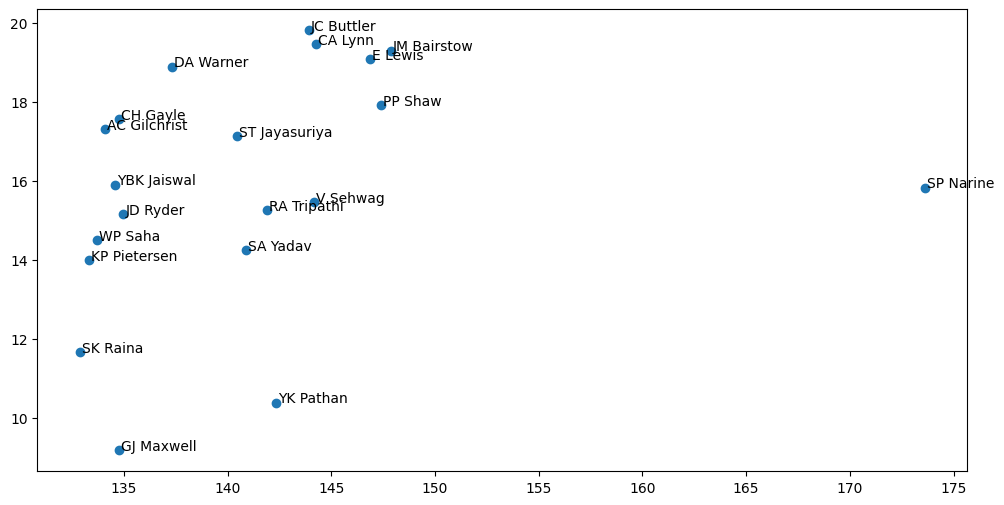

In [10]:
plt.figure(figsize=(12,6))
plt.scatter(dfz.sr,dfz.rpi)
for i in range(len(dfz)):
    plt.text(dfz.sr[i]+0.1,dfz.rpi[i],dfz.batter[i],fontsize=10)
# plt.axhline(np.percentile(dfz.rpi,40))
plt.show()